In [1]:
import redis
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import time
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
redis.__version__

'5.0.2'

In [3]:
class Redis_data:
    def __init__(self,redis_id,redis_port,redis_name,redis_password,spoti_client,spoti_secret):
        """
        In this function We are connecting to the Redis and Spotify to load the data on to the Redis  and to Extract the data from Spotify APi 
        Parameters : 
        r =For Redis Connection
        sp=used for the spotify connection
        """
        self.r = redis.Redis(   host=redis_id, port=redis_port,   username=redis_name,   password=redis_password)
        self.sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=spoti_client, client_secret=spoti_secret))
        self.d_audio=pd.DataFrame(columns=['id','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','duration_ms','time_signature','popularity','playlist'])
    
    def redis_adding(self,aru):
        """"
    
     Retrieves song data from Spotify playlists and stores it in Redis.
     Iterates over a list of Spotify playlist URLs, extracts songs data using the Spotify API,
     and stores each playlist's songs data in Redis. Additionally, constructs and returns a
     DataFrame with basic song details for further analysis.

     Parameters:
        - aru (list of str): List of Spotify playlist URLs.

     Returns:
       - pandas.DataFrame: A DataFrame populated with songs' IDs, names, duration in milliseconds,
        popularity, and the playlist ID they belong to.

     Notes:
        - `self.r` is expected to be a Redis connection instance for data storage.
        - `self.sp` is expected to be a Spotify connection instance for accessing Spotify API.
        - Assumes `json` for serialization/deserialization, `pandas` for DataFrame operations
        """
        for a in aru:
            playlist_url = str(a)
            print(str(playlist_url))
            playlist_id = playlist_url.split('/')[-1].replace("'","").replace("]","")
            songs = json.dumps(self.sp.playlist_tracks(playlist_id))
            try:
                self.r.json().delete(playlist_id)
                self.r.json().set(f'{playlist_id}:1', '.', songs)
                print("Data added to Redis successfully.")
            except Exception as e:
                print(f"Error adding data to Redis: {e}")
            data=json.loads(self.r.json().get(playlist_id))
            print(f'the data reterive from Redis sucess {type(data)}')
            df=pd.DataFrame(
            columns=['id','name','date','No_artist','link','name of movie'])
            print(f"the df file is created successfully{type(df)}")
            print(f"{self.sp.audio_features(data['items'][0]['track']['uri'])[0]}")
            for x in range(len(data['items'])):
                row=list()
                row.append(data['items'][x]['track']['id'])
                row.append(data['items'][x]['track']['name'])
                row.append(data['items'][x]['track']['duration_ms'])
                row.append(data['items'][x]['track']['popularity'])
                row.append(playlist_url.split('/')[-1])
                d_audio.loc[x]=row
        return d_audio


    def redis_ad(self,a):
        """
     Processes and stores Spotify playlist tracks and their audio features into Redis.
     This method takes a single Spotify playlist URL, extracts track information and audio features
     using the Spotify API, and stores this data in Redis. It then constructs a DataFrame with
     tracks' audio features for further analysis.

     Parameters:
     - a (str): Spotify playlist URL.

     Returns:
     - pandas.DataFrame: A DataFrame with audio features and other relevant details for each track
      in the playlist.

     Notes:
     - `self.r` is a Redis connection instance used for data storage and retrieval.
     - `self.sp` is a Spotify connection instance for accessing Spotify API data.
     - Requires `json` for serialization, `pandas` for data handling, and `time` for rate control.
    """
        playlist_url = str(a)
        print(str(playlist_url))
        playlist_id = playlist_url.split('/')[-1]
        data=self.sp.playlist_tracks(playlist_id)
        songs = json.dumps(self.sp.playlist_tracks(playlist_id))
        try:
            self.r.json().delete(f'{playlist_id}:1')
            self.r.json().set(f'{playlist_id}:1', '.', songs)
            print("Data added to Redis successfully.")
        except Exception as e:
            print(f"Error adding data to Redis: {e}")
        data=json.loads(self.r.json().get(f'{playlist_id}:1'))
        d_audio=self.d_audio
        for x in range(len(data['items'])):
            time.sleep(0.5)
            song_audio=json.dumps(self.sp.audio_features(data['items'][x]['track']['uri'])[0])
            k=data['items'][x]['track']['id']
            m=playlist_url.split('/')[-1]
            try:
                self.r.json().delete(f'{m}:{k}')
                self.r.json().set(f'{m}:{k}', '.', song_audio)
            except Exception as e:
                print("Warning Audio is not executed")
            song_measure=json.loads(self.r.json().get(f'{m}:{k}'))
            row=[]
            row.append(data['items'][x]['track']['id'])
            row.append( song_measure['danceability'])
            row.append( song_measure['energy'])
            row.append( song_measure['key'])
            row.append( song_measure['loudness'])
            row.append( song_measure['mode'])
            row.append( song_measure['speechiness'])
            row.append( song_measure['acousticness'])
            row.append( song_measure['instrumentalness'])
            row.append( song_measure['liveness'])
            row.append( song_measure['valence'])
            row.append( song_measure['tempo'])
            row.append( song_measure['type'])
            row.append( song_measure['duration_ms'])
            row.append(song_measure['time_signature'])
            row.append(data['items'][x]['track']['popularity'])
            row.append(playlist_url.split('/')[-1])
            d_audio.loc[x]=row
        return d_audio
    
    
    
    def multiple_spotify(self,arg):
        """
     Aggregates audio features from multiple Spotify playlists into a single DataFrame.

     Iterates over a list of Spotify playlist URLs, retrieves audio features for each playlist
     using the `redis_ad` function, and concatenates these into a single DataFrame. The final
     DataFrame is then saved to a CSV file.

     Parameters:
     - arg (list of str): List of Spotify playlist URLs.

     Returns:
     - pandas.DataFrame: A combined DataFrame with audio features from all provided playlists.

     Notes:
     - Relies on `self.redis_ad` for fetching and processing individual playlist data.
     - Saves the aggregated DataFrame to 'song_values.csv'.
    """
        data_frame=self.d_audio
        for a in arg:
            print(a)
            data_frame=pd.concat([data_frame,self.redis_ad(a)],ignore_index=True)
        filename = 'song_values.csv'
        data_frame.to_csv(filename, index=False)
        return data_frame

In [4]:
redis_id="redis-17615.c281.us-east-1-2.ec2.cloud.redislabs.com"
port=17615
username="default"
password="mf6oPP3htJjZusAg2RQbRD9DLfLCLpFE"
client_id ='bf3bc79bd4764a27be8b3f086befdbe0'# '56535f9b7d4b4e068f8e639365c9d255'
client_secret = '9c5afcf7bd0d44b58d87137062f0672c'#'1c92f0b0d2974b40a7f6afb4d7f72b88'
o=Redis_data(redis_id,port,username,password,client_id,client_secret)

In [5]:
json.__version__

'2.0.9'

In [7]:
links=['https://open.spotify.com/playlist/7p3Bd6ezuH2UaSEpqSJYs0','https://open.spotify.com/playlist/1pHX5NHrCG5vhhke9f3Nbf','https://open.spotify.com/playlist/656d91JastxforR4ac4eIs','https://open.spotify.com/playlist/3EZHPUtbIDHnHeiu8e6t5C','https://open.spotify.com/playlist/1llHjtjECBo12ChwOGe38L','https://open.spotify.com/playlist/7KzWAfT4teGEHlHhhcD0Kp','https://open.spotify.com/playlist/0FQP0EOKSWK4O7LgRhGz1L']
data_frame=o.multiple_spotify(links)

https://open.spotify.com/playlist/7p3Bd6ezuH2UaSEpqSJYs0
https://open.spotify.com/playlist/7p3Bd6ezuH2UaSEpqSJYs0


Data added to Redis successfully.
https://open.spotify.com/playlist/1pHX5NHrCG5vhhke9f3Nbf
https://open.spotify.com/playlist/1pHX5NHrCG5vhhke9f3Nbf
Data added to Redis successfully.
https://open.spotify.com/playlist/656d91JastxforR4ac4eIs
https://open.spotify.com/playlist/656d91JastxforR4ac4eIs
Data added to Redis successfully.
https://open.spotify.com/playlist/3EZHPUtbIDHnHeiu8e6t5C
https://open.spotify.com/playlist/3EZHPUtbIDHnHeiu8e6t5C
Data added to Redis successfully.
https://open.spotify.com/playlist/1llHjtjECBo12ChwOGe38L
https://open.spotify.com/playlist/1llHjtjECBo12ChwOGe38L
Data added to Redis successfully.
https://open.spotify.com/playlist/7KzWAfT4teGEHlHhhcD0Kp
https://open.spotify.com/playlist/7KzWAfT4teGEHlHhhcD0Kp
Data added to Redis successfully.
https://open.spotify.com/playlist/0FQP0EOKSWK4O7LgRhGz1L
https://open.spotify.com/playlist/0FQP0EOKSWK4O7LgRhGz1L
Data added to Redis successfully.


In [8]:
df=pd.read_csv("song_values.csv")

Machine learnig : 
the idea is to predict the popularity using the autio metrics is there any link ?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                800 non-null    object 
 1   danceability      800 non-null    float64
 2   energy            800 non-null    float64
 3   key               800 non-null    int64  
 4   loudness          800 non-null    float64
 5   mode              800 non-null    int64  
 6   speechiness       800 non-null    float64
 7   acousticness      800 non-null    float64
 8   instrumentalness  800 non-null    float64
 9   liveness          800 non-null    float64
 10  valence           800 non-null    float64
 11  tempo             800 non-null    float64
 12  type              800 non-null    object 
 13  duration_ms       800 non-null    int64  
 14  time_signature    800 non-null    int64  
 15  popularity        800 non-null    int64  
 16  playlist          800 non-null    object 
dt

In [10]:
df=df.drop(['id','playlist','type'],axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      800 non-null    float64
 1   energy            800 non-null    float64
 2   key               800 non-null    int64  
 3   loudness          800 non-null    float64
 4   mode              800 non-null    int64  
 5   speechiness       800 non-null    float64
 6   acousticness      800 non-null    float64
 7   instrumentalness  800 non-null    float64
 8   liveness          800 non-null    float64
 9   valence           800 non-null    float64
 10  tempo             800 non-null    float64
 11  duration_ms       800 non-null    int64  
 12  time_signature    800 non-null    int64  
 13  popularity        800 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 87.6 KB


In [12]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,0.773,0.750,8,-4.009,0,0.117,0.109,0.00000,0.1740,0.783,123.426,220587,4,85
1,0.509,0.542,3,-8.027,0,0.442,0.019,0.00639,0.2300,0.151,97.767,78681,4,80
2,0.740,0.613,8,-4.880,1,0.145,0.258,0.00372,0.1230,0.473,75.023,166606,4,84
3,0.759,0.538,8,-8.256,0,0.384,0.151,0.00000,0.1260,0.831,146.933,184490,4,71
4,0.763,0.726,1,-6.405,1,0.282,0.259,0.00000,0.0976,0.349,139.059,126346,4,84


In [13]:
df.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
danceability,1.000000,0.095523,-0.023435,0.050459,0.005746,0.120215,-0.247009,0.005162,-0.090260,0.379517,-0.146504,-0.123020,0.212324,-0.039932
energy,0.095523,1.000000,-0.044758,0.741333,-0.032415,0.042472,-0.440073,-0.183092,0.087418,0.465281,-0.018305,0.276155,0.075859,0.026552
key,-0.023435,-0.044758,1.000000,-0.070448,-0.170642,-0.004656,-0.007462,0.023796,0.025570,0.071530,0.008100,0.000948,-0.038969,0.015268
loudness,0.050459,0.741333,-0.070448,1.000000,-0.005044,0.001332,-0.401969,-0.285998,0.034992,0.290828,0.031115,0.189564,0.018067,0.122885
mode,0.005746,-0.032415,-0.170642,-0.005044,1.000000,0.088618,0.008502,0.062207,-0.091795,-0.093117,0.016517,0.026115,-0.036344,0.008770
speechiness,0.120215,0.042472,-0.004656,0.001332,0.088618,1.000000,-0.094735,-0.074627,-0.004506,-0.034230,0.196698,-0.279503,0.026541,0.136640
acousticness,-0.247009,-0.440073,-0.007462,-0.401969,0.008502,-0.094735,1.000000,0.148288,-0.056267,-0.146732,-0.006260,-0.114376,-0.214644,-0.070102
instrumentalness,0.005162,-0.183092,0.023796,-0.285998,0.062207,-0.074627,0.148288,1.000000,0.037741,-0.141930,-0.021207,-0.232760,0.009670,-0.109738
liveness,-0.090260,0.087418,0.025570,0.034992,-0.091795,-0.004506,-0.056267,0.037741,1.000000,0.010453,-0.052204,-0.035360,-0.020124,0.059168
valence,0.379517,0.465281,0.071530,0.290828,-0.093117,-0.034230,-0.146732,-0.141930,0.010453,1.000000,-0.053928,0.210762,0.081451,-0.109412


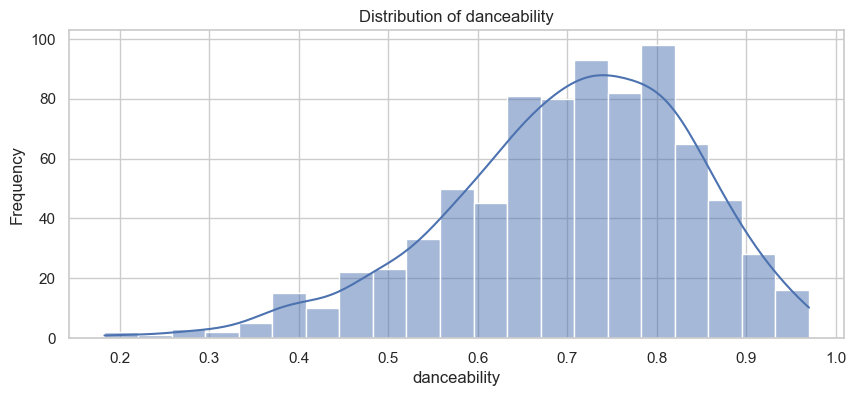

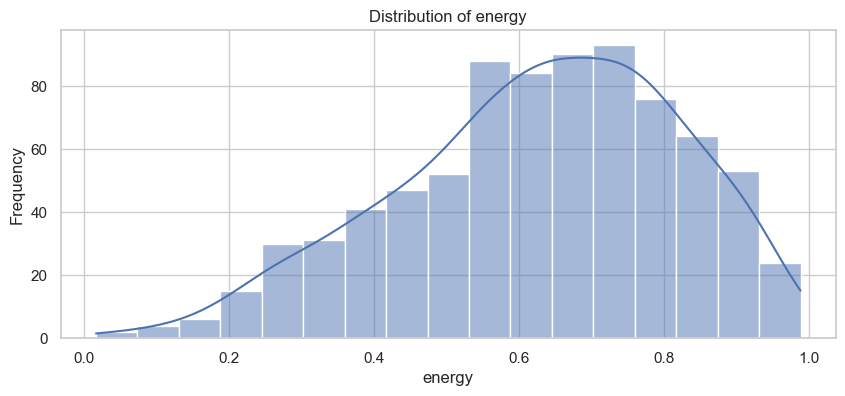

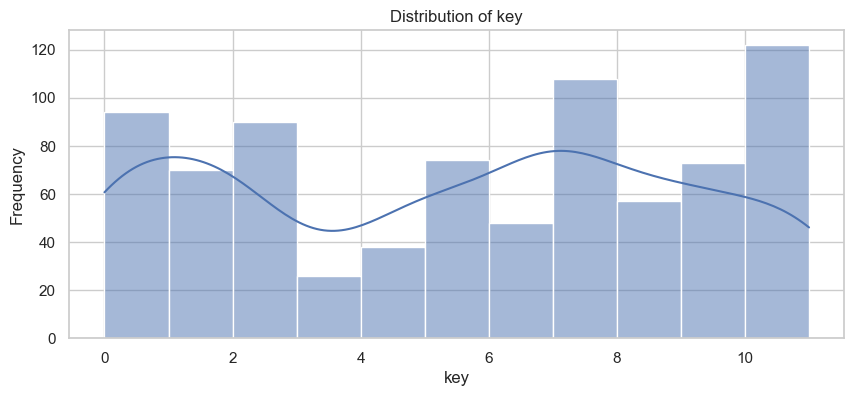

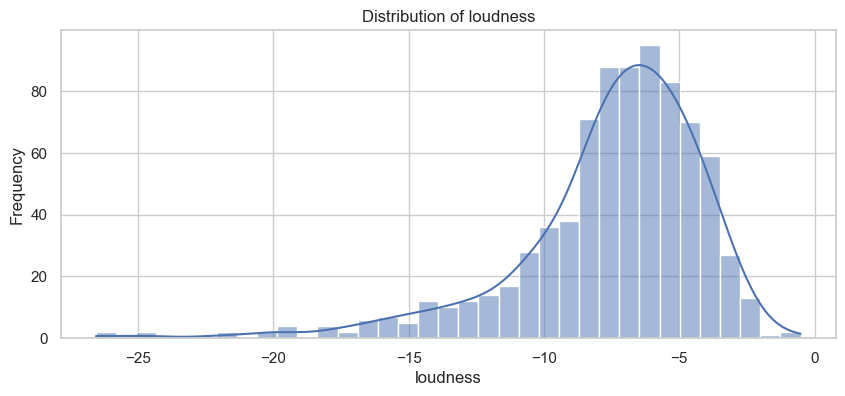

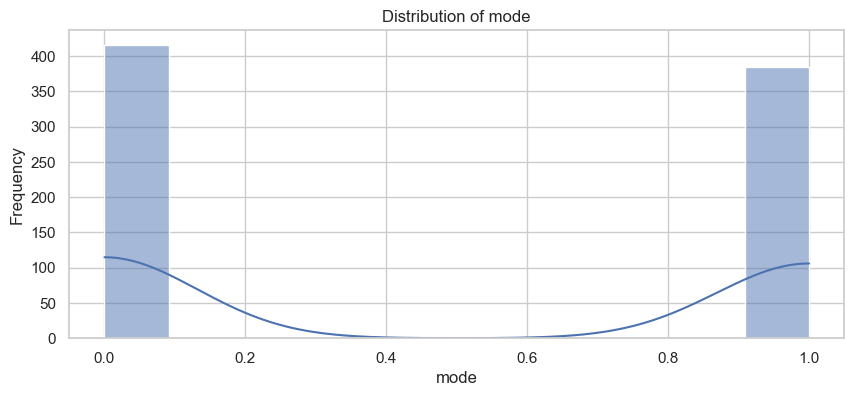

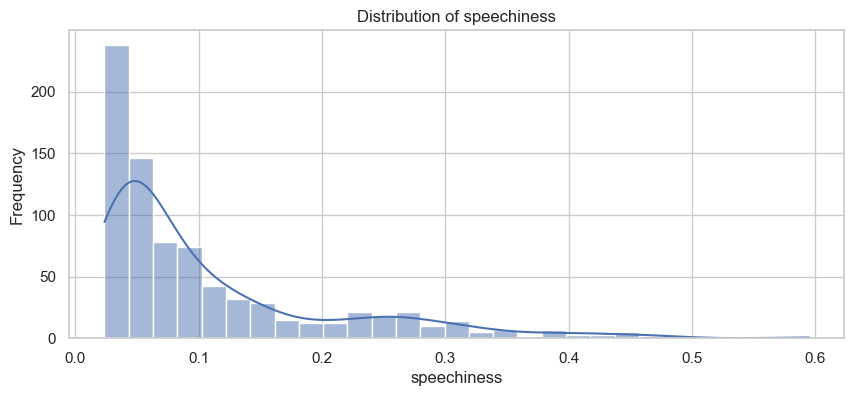

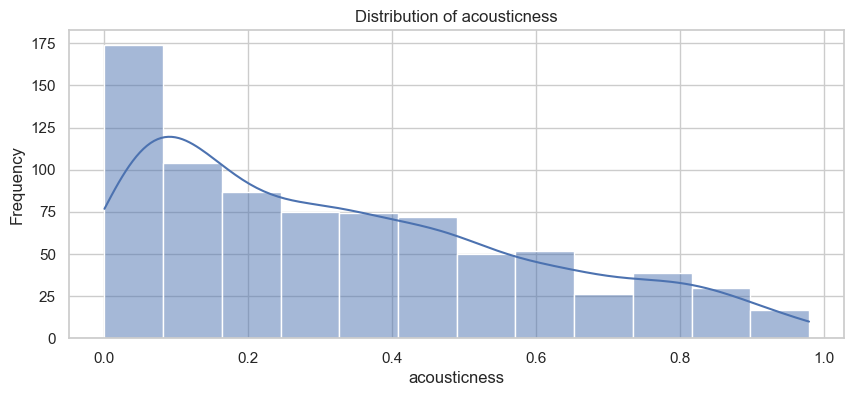

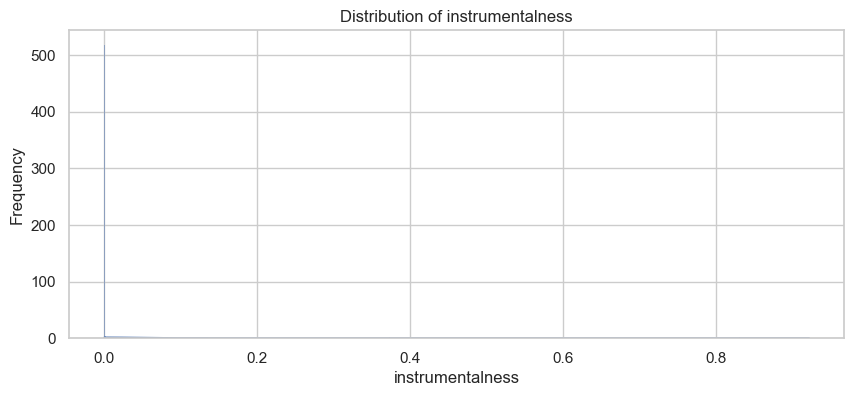

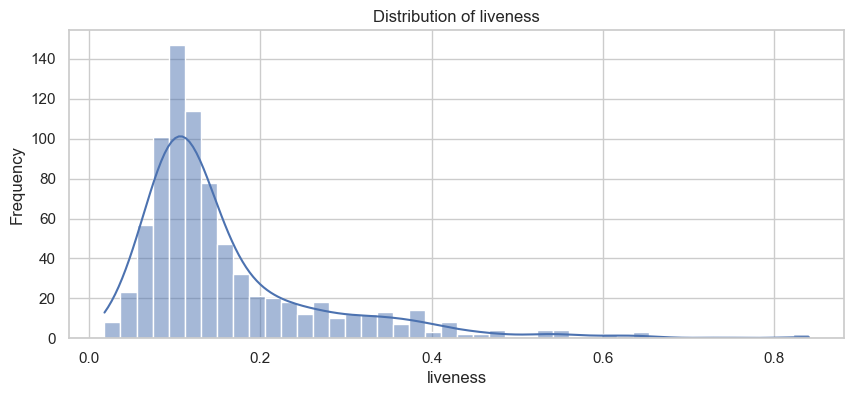

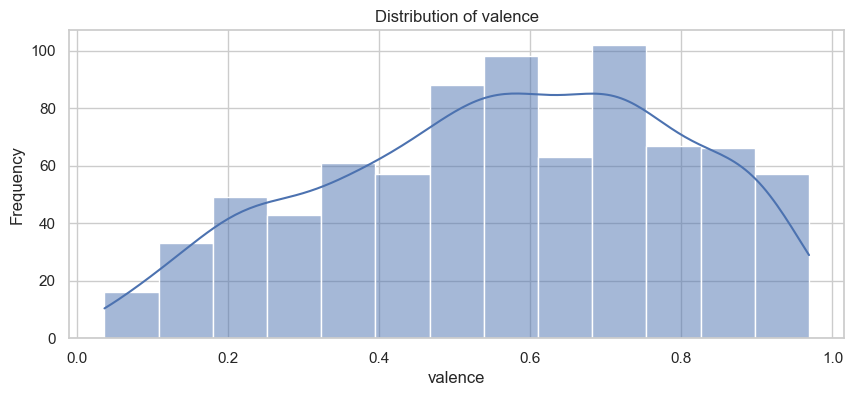

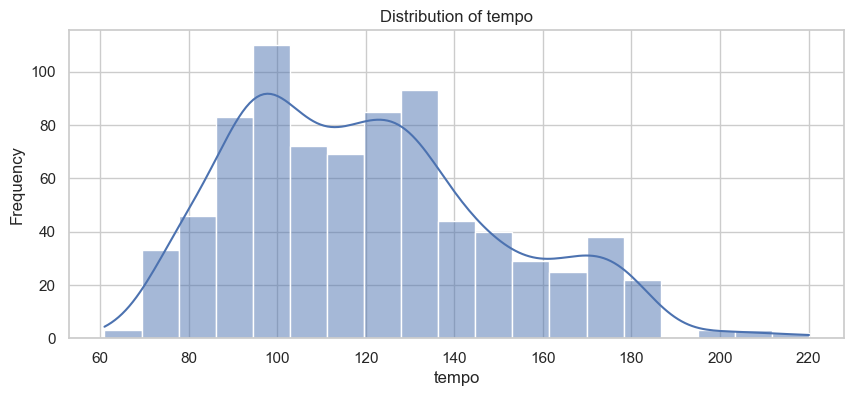

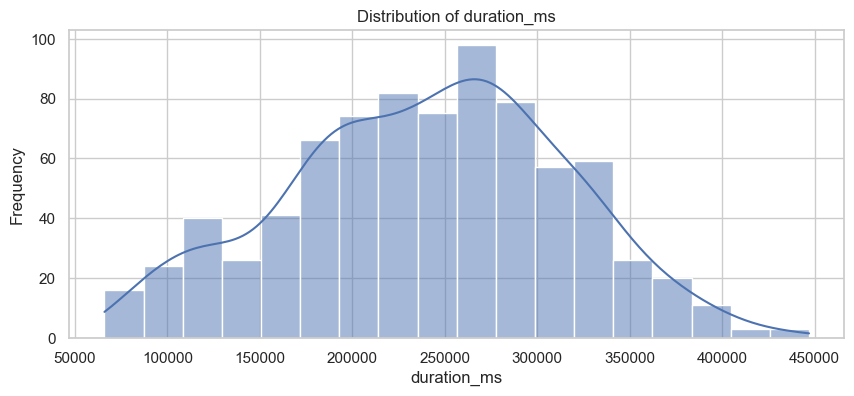

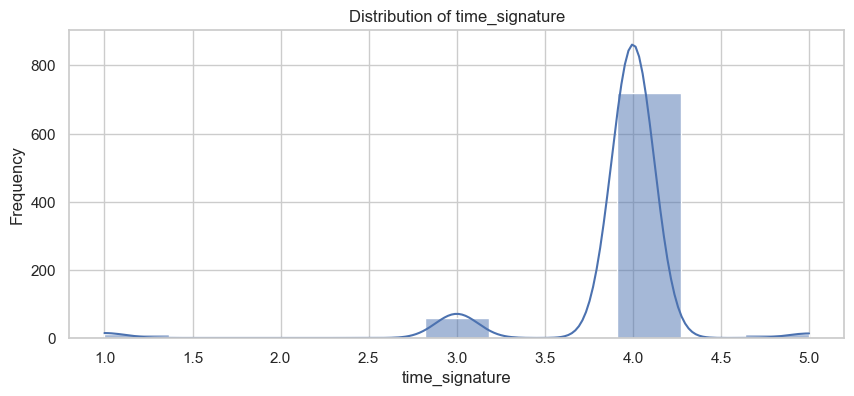

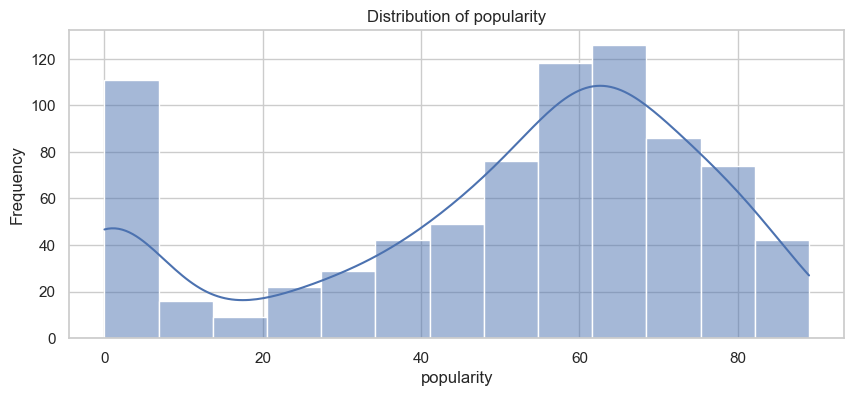

In [14]:
import seaborn as sns

sns.set(style='whitegrid')

for column in df.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[column], kde=True) 
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

<AxesSubplot:>

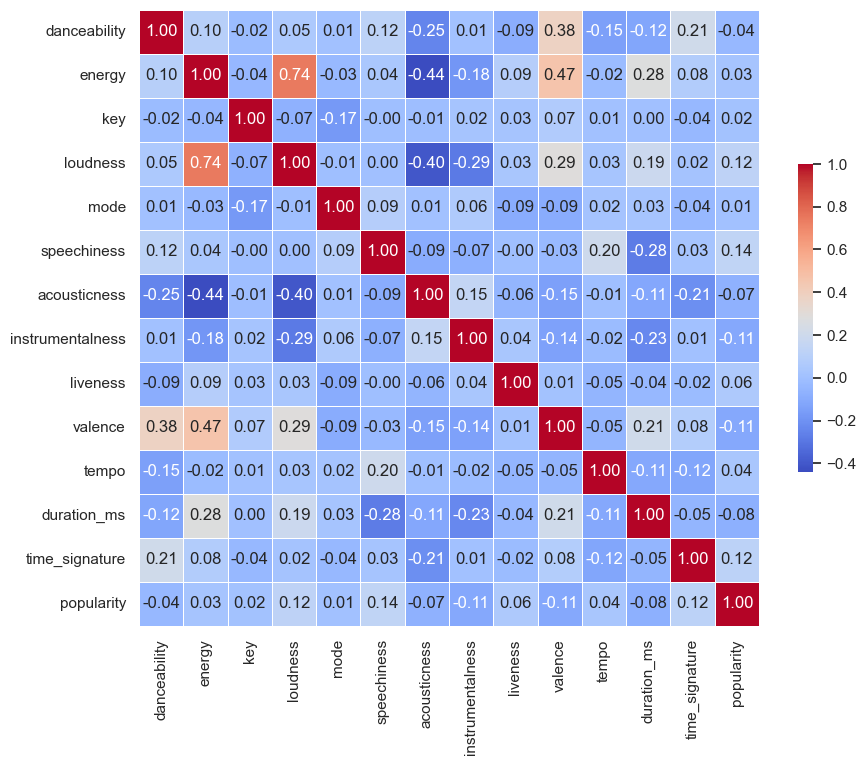

In [15]:
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=df.corr().columns, yticklabels=df.corr().columns,
            linewidths=.5, cbar_kws={"shrink": .5})

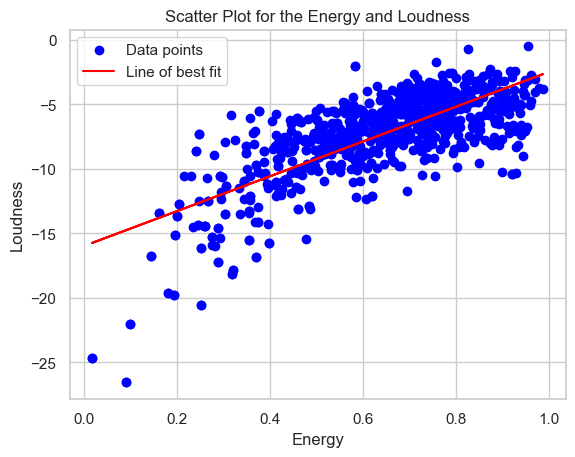

In [16]:
X=df['energy']
y=df['loudness']
a, b = np.polyfit(X, y, 1)
plt.scatter(X, y, color='blue', label='Data points')

# Generate values for the line of best fit
y_fit = np.array(X) * a + b

# Add the line of best fit to the plot
plt.plot(X, y_fit, color='red', label='Line of best fit')

# Adding title and labels
plt.title('Scatter Plot for the Energy and Loudness')
plt.xlabel('Energy')
plt.ylabel('Loudness')

# Show legend
plt.legend()

# Display the plot
plt.show()

Both the Energy and the Loudness are strongly releated of 0.74

In [17]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 654.6890754497734
R-squared: 0.10068053896610374


In [20]:
pip install xgboost

   ---------------------------------------- 99.8/99.8 MB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_regr = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.01,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 50)

xgb_regr.fit(X_train, y_train)

y_pred = xgb_regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
 
r2_gradient_boosting = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R^2: {r2}")



MSE: 675.3328906125777
R^2: 0.10068053896610374
